## Today you are a Machine Learning Engineer at the Department of Business Intelligence at Target Cosmetics!
This work relies on processed data from Kaggle https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop

This work is motivated by the publication https://arxiv.org/pdf/2010.02503.pdf and https://arxiv.org/pdf/2102.01625.pdf

This data is similar to the Ecommerce data we looked at last week, but for cosmetics retail. Also, the data indicating time-of-day, day-of-week, month, and year of the purchase have been converted to one-hot representations of these categories.

Our objective in this notebook will be to discover some structure in this data by applying some of the **unsupervised learning** methods covered in class this week.

You have access to 250,000 user-journeys and you have been asked to:
1. Find patterns among customer purchasing behaviors to identify categories of customers, i.e. how many categories of customers are there based on their purchasing behavior?
2. Visually inspect the customer categories to identify the distinctive categories and their most important features.

## Task 1: Load in the data

If running in Google Colab, run this first:

In [127]:
#from google.colab import drive
#drive.mount('/content/drive')

1. Import pandas (nickname `pd`) and use `pd.read_csv()` to read in the `Cosmetics_data_2019.csv` dataset, saving it as `df`. Look at the first few rows with the `.head()` method.

    Look at the data to get a basic understanding of the dataset.

In [128]:
import pandas as pd
!pip install scikit-learn==0.23.2 yellowbrick==1.3
#!conda update -n base -c defaults conda
#!conda install -c districtdatalabs yellowbrick

df = pd.read_csv('data/Cosmetics_data_2019.csv')
df.head()

,user_id,product_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Nov,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Purchase
0,537190108,27762,2,2,4749,19.03,19.03,0,1,1,...,1,0,0,0,0,0,1,0,0,0
1,577668451,5865119,1,1,0,4.60,4.60,0,1,0,...,1,0,1,0,0,0,0,0,0,0
2,607369766,5922121,1,1,0,35.71,35.71,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,572456715,5723529,1,1,0,2.94,2.94,1,0,0,...,1,0,0,0,1,0,0,0,0,0
4,566667766,5823646,1,1,0,5.22,5.22,0,1,0,...,0,0,0,0,0,1,0,0,0,0


2. What percentage of interactions (rows) result in a purchase?

    Do people mostly buy what they look at or do they do a lot of "window shopping" (shopping around without buying)?

In [129]:
import numpy as np
purchase_values = df['Purchase'].values
print(purchase_values)
print(f'Percentage of interactions resulting in a purchase = {(np.sum(purchase_values)/len(purchase_values))*100}')

[0 0 0 ... 0 0 1]
Percentage of interactions resulting in a purchase = 12.0684


3. Drop `'user_id'` and `'product_id'` from the DataFrame. We don't be using these columns.

    Use the `.head()` method to verify that the DataFrame has been updated.

In [130]:
df = df.drop(columns=['user_id','product_id'])
df.head()
#df.shape

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,InsessionCart,InsessionView,...,Nov,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Purchase
0,2,2,4749,19.03,19.03,0,1,1,1,2,...,1,0,0,0,0,0,1,0,0,0
1,1,1,0,4.60,4.60,0,1,0,0,1,...,1,0,1,0,0,0,0,0,0,0
2,1,1,0,35.71,35.71,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,1,1,0,2.94,2.94,1,0,0,13,13,...,1,0,0,0,1,0,0,0,0,0
4,1,1,0,5.22,5.22,0,1,0,0,3,...,0,0,0,0,0,1,0,0,0,0


4. Create a matrix of features (AKA the "design matrix") `X` from every column in the DataFrame except for `Purchase` since it's like a label. We will be doing an unsupervised task, so will only use the features, though we'll keep the `Purchase` column in the DataFrame so we can use it for some analysis at the end.

In [131]:
X = df.drop(columns=['Purchase'])
Y = df['Purchase']

## Task 2: Apply dimensionality reduction and K-means clustering

We're going to do two main things in this task: 
  * Apply dimensionality reduction to `X`.
    - First we'll try PCA, reducing the number of features down to **5**
    - Then we'll also try t-SNE. t-SNE is a lot slower than PCA so we'll have you run t-SNE on a smaller subsample of the data, and we'll use 3 instead of 5 output features.
  * Apply K-means clustering on the dimensionality-reduced data, using different values of "K". This is one way of assessing the quality of the dimensionality reduction. We'll summarize all this information in a single plot, the "Elbow" plot.

1. Use the sklearn `PCA` module you've imported above to produce `X_reduced_PCA`, a version of the data in `X` has been dimensionality-reduced by PCA. Use 5 PCA components, so `X_reduced_PCA` should have 5 columns.

    Look at the shape of `X_reduced_PCA` to verify it's the correct size.

In [132]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_reduced_PCA = pca.fit_transform(X)
print(X_reduced_PCA.shape)

(250000, 5)


2. Now do dimensionality reduction with t-SNE. You can use the [TSNE module](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) in `sklearn.manifold`

    Certain implementations of t-SNE can be slow, including scikit-learn's, so just fit it on the first 10000 samples of your data. Also, pick n_components=3 and perplexity=20. This can take a little while, be patient :)

    Save the t-SNE-reduced version of your data as `X_reduced_tSNE`

In [133]:
import sklearn.manifold

tsne_model = sklearn.manifold.TSNE(n_components=3, perplexity=20)
x_temp = X[:10000]
X_reduced_tSNE = tsne_model.fit_transform(x_temp)

Now we'll use the [KMeans module](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans) in sklearn.cluster, to fit Kmeans clusterings of the data. We'll use an elbow plot to determine the optimal value of $k$.

3. First we'll do a $k$-means of the PCA-reduced data.

    We don't know the best value of $k$ (the number of clusters) *a priori*, so we'll try all values of $k$ from 1 and 10.

    Build a $k$-means model for each value from 1 to 21 and save the sum of squared distances for each $k$-means value. You can get the sum of squared distances with the `inertia_` attribute.
    
    Plot the `inertia_` values to find the "elbow".

**Approach 1 - Elbow graph using Yellowbrick**

dict_keys(['ax', 'estimator', 'k', 'locate_elbow', 'metric', 'timings']) 




KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=19), k=None)

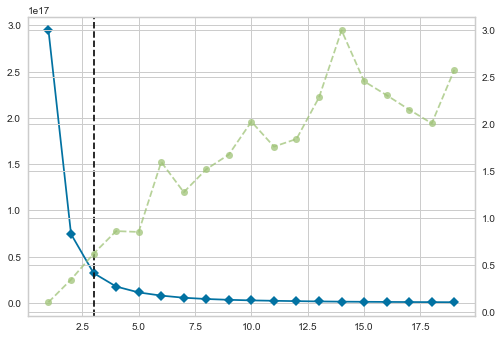

In [134]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(X_reduced_PCA) 

**Approach 2 - Using inertia data**

In [135]:
from sklearn.cluster import KMeans
number_clusters = 21
sq = []
for i in range(1, number_clusters) :
  km_model = KMeans (n_clusters=i)
  km_model.fit(X_reduced_PCA)
  sq.append(km_model.inertia_)


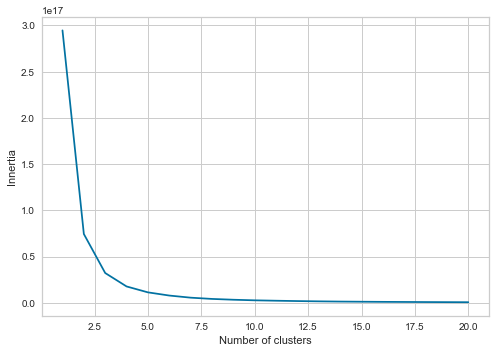

In [136]:
number_clusters = range(1,21)
plt.plot(number_clusters, sq)
plt.xlabel('Number of clusters')
plt.ylabel('Innertia')
plt.show()

4. Make a similar elbow plot for $k$-means for the t-SNE-reduced data.

**Approach 1 - Yellowbrick Elbow visualizer**

dict_keys(['ax', 'estimator', 'k', 'locate_elbow', 'metric', 'timings']) 




KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=20), k=None)

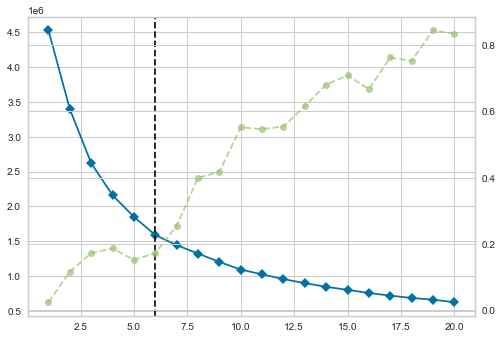

In [137]:
model_tsne = KMeans()
visualizer = KElbowVisualizer(model_tsne, k=(1,21))
visualizer.fit(X_reduced_tSNE) 

**Approach 2 - Using inertia data**

5. Discuss with your breakout room partners what you can learn from these Elbow plots.

In [138]:
number_clusters = 21
sq = []
for i in range(1, number_clusters) :
  km_model = KMeans (n_clusters=i)
  km_model.fit(X_reduced_tSNE)
  sq.append(km_model.inertia_)

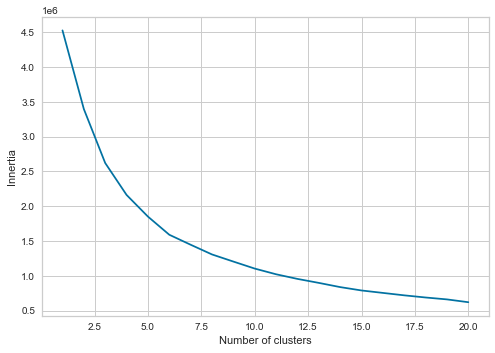

In [139]:
number_clusters = range(1,21)
plt.plot(number_clusters, sq)
plt.xlabel('Number of clusters')
plt.ylabel('Innertia')
plt.show()

6. Use the eblow plot to pick a value of $k$ to use for $k$-means on the PCA-reduced data.

    Fit a $k$-means model to `X_reduced_PCA` with that value of $k$ and generate an array `cluster_ids` that labels each datapoint in `X_reduced_PCA` with the cluster ID (0 to k-1) that $k$-means assigns to it.

In [140]:
n = 6 
clusters = KMeans(n_clusters = n)
values = np.array(clusters.fit_predict(X_reduced_PCA))
print(np.unique(values))

[0 1 2 3 4 5]


7. Add a column `ClusterID` to the DataFrame with the cluster id values (0, 1, or 2).

    Use the `.head()` method to verify the column has been added.

In [141]:
df['ClusterID'] = values
df.head()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,InsessionCart,InsessionView,...,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Purchase,ClusterID
0,2,2,4749,19.03,19.03,0,1,1,1,2,...,0,0,0,0,0,1,0,0,0,0
1,1,1,0,4.60,4.60,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,1,1,0,35.71,35.71,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,1,1,0,2.94,2.94,1,0,0,13,13,...,0,0,0,1,0,0,0,0,0,0
4,1,1,0,5.22,5.22,0,1,0,0,3,...,0,0,0,0,1,0,0,0,0,0


8. Run the following line to save the DataFrame to a csv file `clustered_data_cosmetics.csv`.

In [142]:
df.to_csv('clustered_data_cosmetics.csv', index=False)

## Task 3: Visualize the clusters [Instructor Led]

We will be using `tensorflow` and `tensorboard` to do some visualizations. For more info, review this tutorial: [Visualizing Data using the Embedding Projector in TensorBoard](https://colab.research.google.com/drive/1-PUVjf4eNO8QzF27lbBg6OT-yTNlBgD7).

1. Load in the data with clustering labels.

In [143]:
df = pd.read_csv("clustered_data_cosmetics.csv")
df.head()
X = df.iloc[:, 0: -2].values
cluster_ids = df.ClusterID.values

2. Define functions for visualizing and saving results.

In [144]:
def register_embedding(embedding_tensor_name, meta_data_fname, log_dir):
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = embedding_tensor_name
    embedding.metadata_path = meta_data_fname
    projector.visualize_embeddings(log_dir, config)

def save_labels_tsv(labels, filepath, log_dir):
    with open(os.path.join(log_dir, filepath), 'w') as f:
        for label in labels:
            f.write('{}\n'.format(label))

3. Create a directory where we can store logs for tensorboard to use.

In [145]:
import os
## Get working directory
PATH = os.getcwd()
## Path to save the embedding and checkpoints generated
os.mkdir(PATH + '/project-tensorboard/')
LOG_DIR = PATH + '/project-tensorboard/log-1'
os.mkdir(LOG_DIR)

4. Run the visualization.

In [146]:
from tensorboard.plugins import projector

META_DATA_FNAME = 'meta_cos_reduction1.tsv'  # Labels will be stored here
EMBEDDINGS_TENSOR_NAME = 'sample_data_cos_reduction1'
EMBEDDINGS_FPATH = os.path.join(LOG_DIR, EMBEDDINGS_TENSOR_NAME + '.ckpt')
STEP = 0

register_embedding(EMBEDDINGS_TENSOR_NAME, META_DATA_FNAME, LOG_DIR)
save_labels_tsv(cluster_ids, META_DATA_FNAME, LOG_DIR)

In [147]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
tensor_embeddings = tf.Variable(X, name=EMBEDDINGS_TENSOR_NAME)
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())
saver = tf.compat.v1.train.Saver()
saver.save(sess, EMBEDDINGS_FPATH, STEP)
sess.close()

Note: If you're running this notebook locally, you can start tensorboard from the command line `tensorboard --logdir <path to the log directory>`. To use it *embedded in a Colab notebook* you have to do the following

In [148]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [149]:
%tensorboard --logdir project-tensorboard/log-1

Launching TensorBoard...

![PCA Support Image](PCA support images/PCA.png)

![tsne Support Image](PCA support images/tsne.png)

## Task 4: Analysis of clusters.
Now that the records have been clustered, we can do some analysis on the clusters.

1. For each cluster, calculate the representation percentage (i.e. what percentage of the dataset's samples belong to that cluster) and purchase percentage (i.e. what percentage of samples in each cluster resulted in a purchase)

    Do the different clusters vary in their purchase ratio? If so by how much?

In [150]:
for i in range (0,6):
  cluster_values_df = df.loc[df['ClusterID'] == i]
  purchase_values_df = cluster_values_df.loc[df['Purchase'] == 1]
  representation_percentage = (len(cluster_values_df) * 100 ) / len(df)
  purchase_percentage = (len(purchase_values_df) * 100 ) / len(cluster_values_df)
  print('Cluster #',i)
  print('Representation Percentage',representation_percentage, '%')
  print('Purchase Percentage', purchase_percentage, '%')
  print('------------------------')


Cluster # 0
Representation Percentage 89.9308 %
Purchase Percentage 11.004905994386796 %
------------------------
Cluster # 1
Representation Percentage 0.4332 %
Purchase Percentage 32.31763619575254 %
------------------------
Cluster # 2
Representation Percentage 1.3388 %
Purchase Percentage 19.15147893636092 %
------------------------
Cluster # 3
Representation Percentage 0.7984 %
Purchase Percentage 24.749498997995993 %
------------------------
Cluster # 4
Representation Percentage 4.9972 %
Purchase Percentage 21.868246217882014 %
------------------------
Cluster # 5
Representation Percentage 2.5016 %
Purchase Percentage 19.379597057882954 %
------------------------


2. Plot the discriminating charecteristics of each feature to separate purchase vs. not-purchase events. You could do this many ways, it's up to you. One suggestion we'll give is to use a seaborn distplot on each feature separately. You can do this one cluster at a time to see if there are any big differences between the distributions of feature values for different clusters.

    Note: Feel free to reduce the feature set to make things more manageable. For example use this subset of the columns:
    
    ```
    selected_columns = ['NumOfEventsInJourney', 'NumSessions', 'interactionTime',
                        'maxPrice', 'minPrice', 'NumCart', 'NumView', 'NumRemove',
                        'InsessionCart', 'InsessionView', 'InsessionRemove',
                        'Purchase']
    ```
    
    Share and discuss your graph with your group.

In [151]:
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

selected_columns = ['NumOfEventsInJourney', 'NumSessions', 'interactionTime',
                     'maxPrice', 'minPrice', 'NumCart', 'NumView', 'NumRemove',
                     'InsessionCart', 'InsessionView', 'InsessionRemove',
                     'Purchase']

def plot_discriminating_features(clusterID):
  result = df[df['ClusterID'] == clusterID]
  result = result[selected_columns]
  fig = plt.figure(figsize = (20, 25))
  for i,item in enumerate(result.columns):
    plt.subplot(4, 3, i+1)
    sb.distplot(result[item][result['Purchase']==0], color='b', label = 'No Purchase')
    sb.distplot(result[item][result['Purchase']==1], color='r', label = 'Purchase')
    plt.legend(loc='best')
  fig.suptitle('Feature Analysis')
  fig.tight_layout()
  fig.subplots_adjust(top=0.95)
  plt.show()

**Cluster 0**

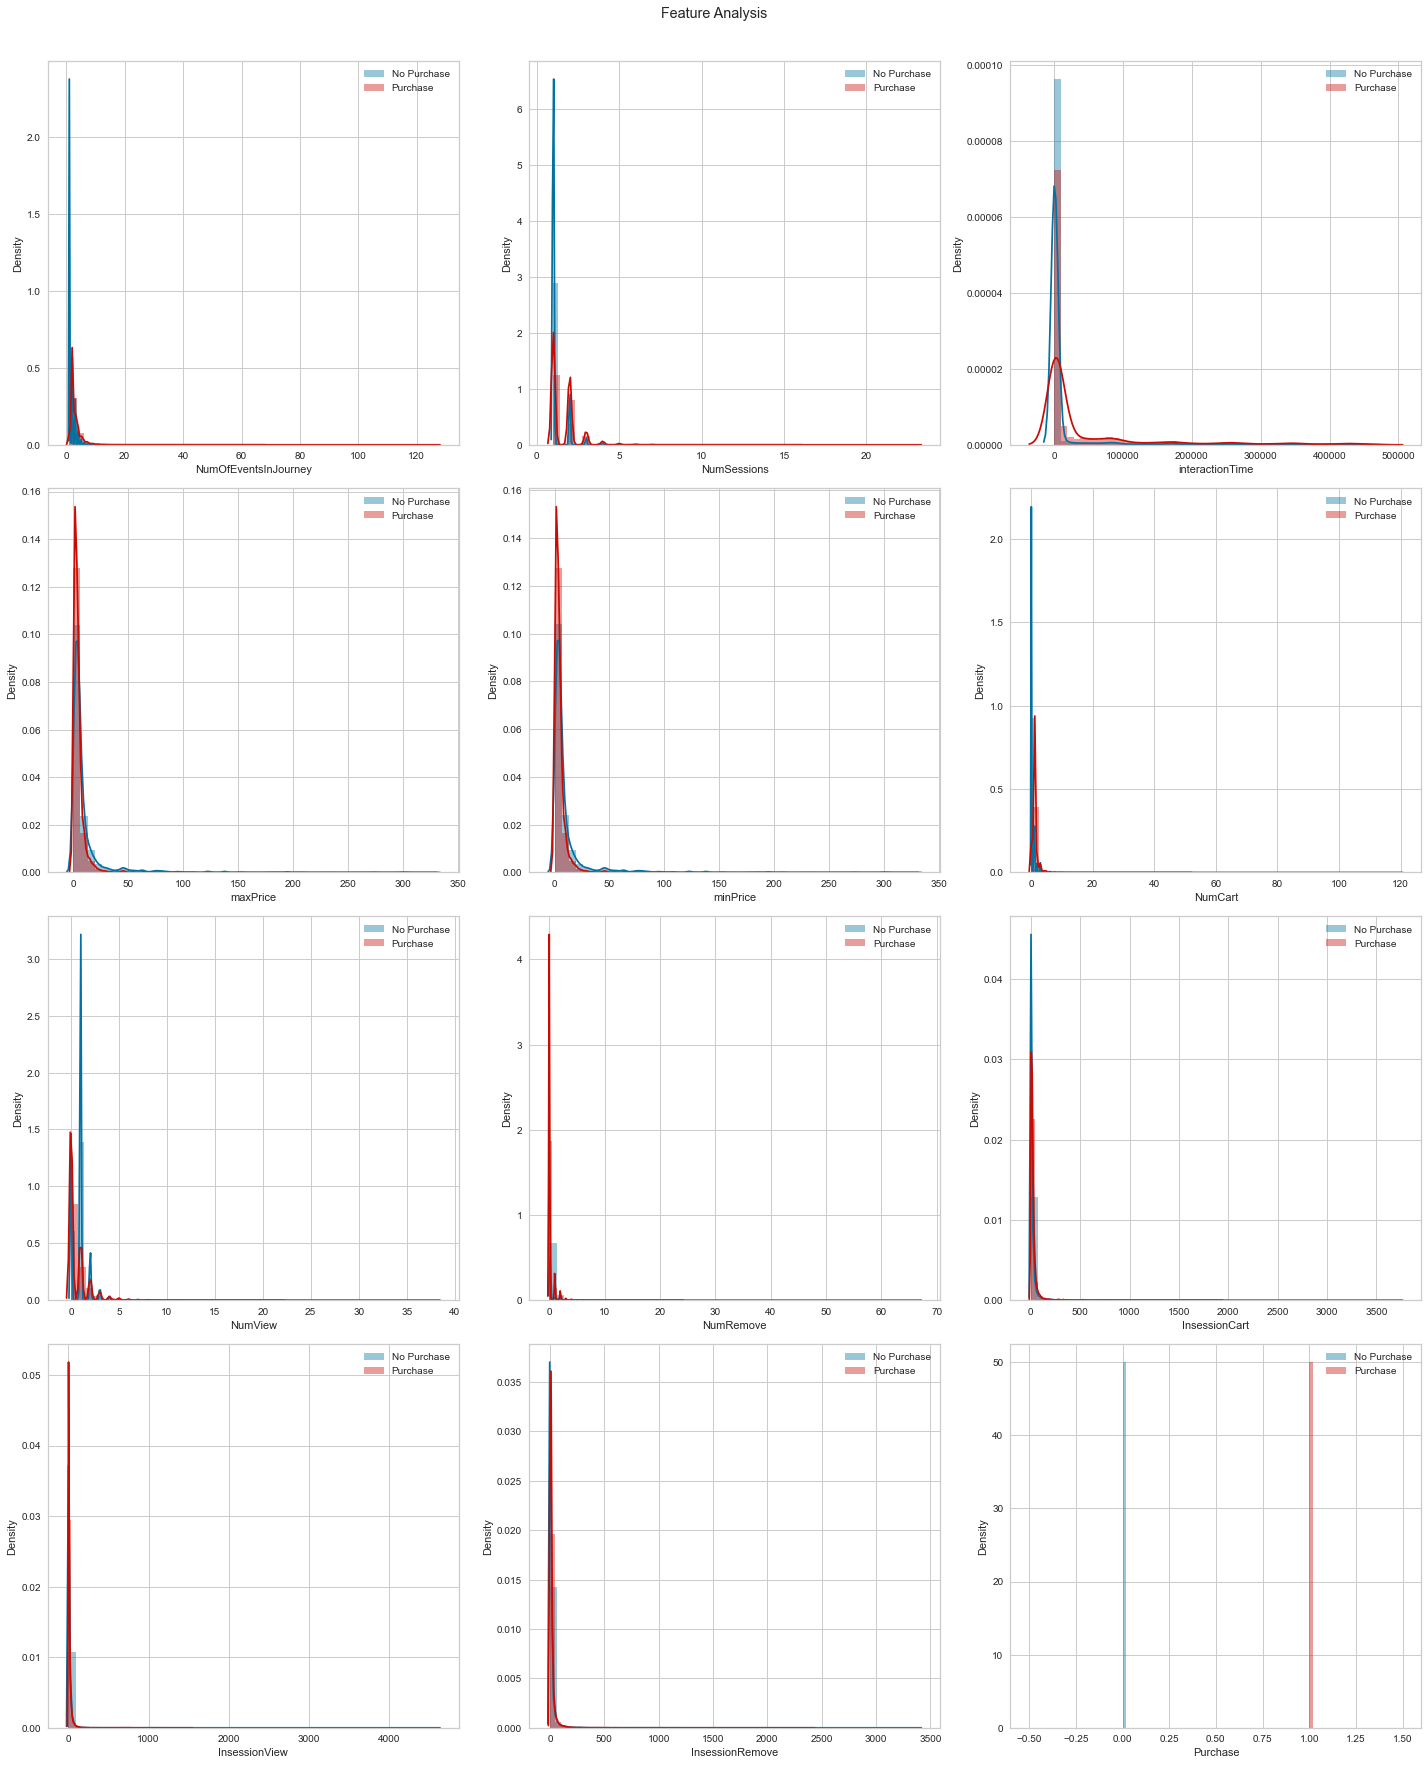

In [152]:
plot_discriminating_features(0)

**Cluster 1**

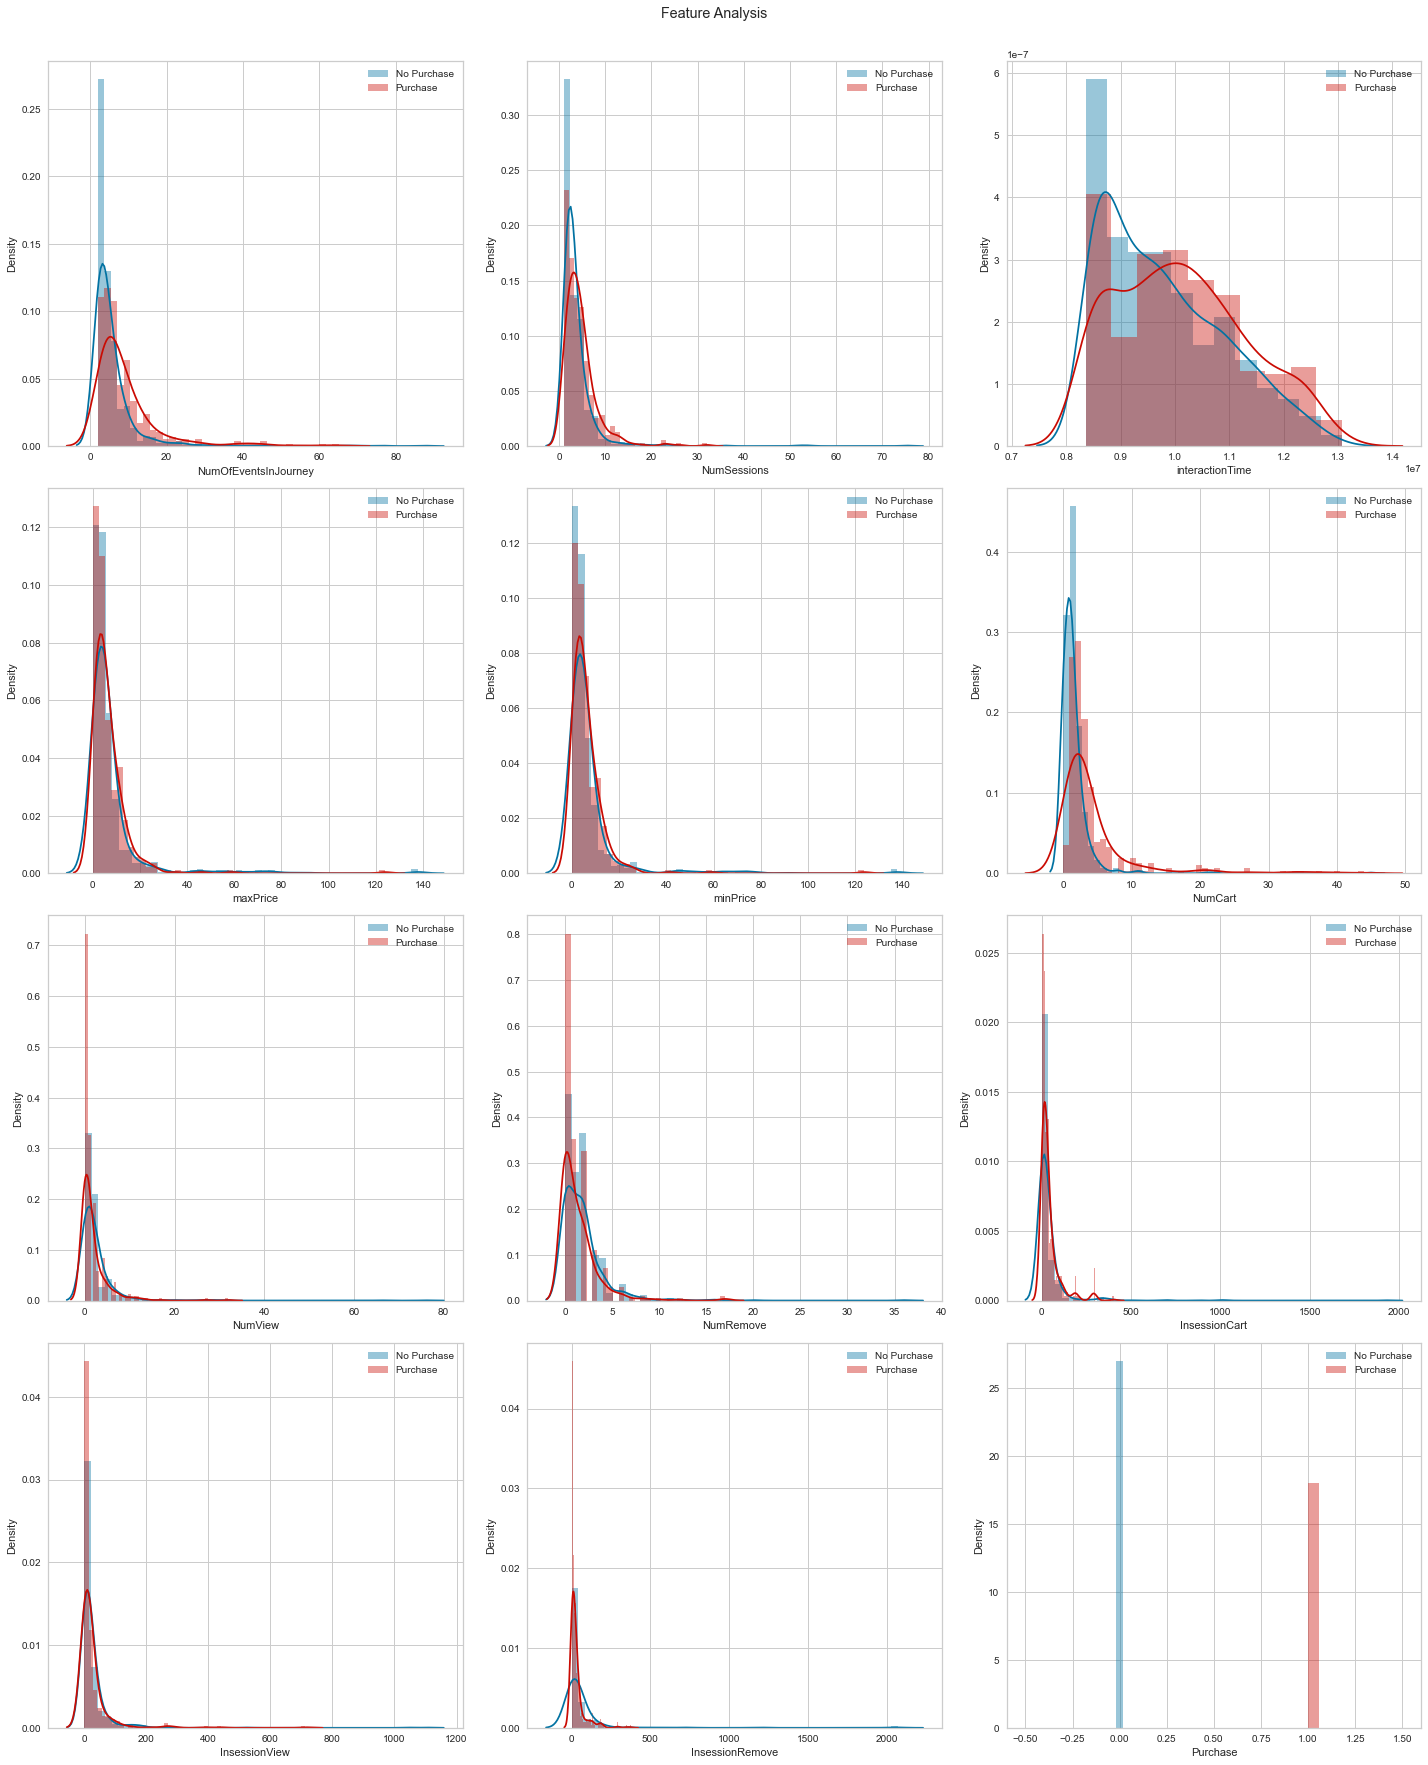

In [153]:
plot_discriminating_features(1)

**Cluster 2**

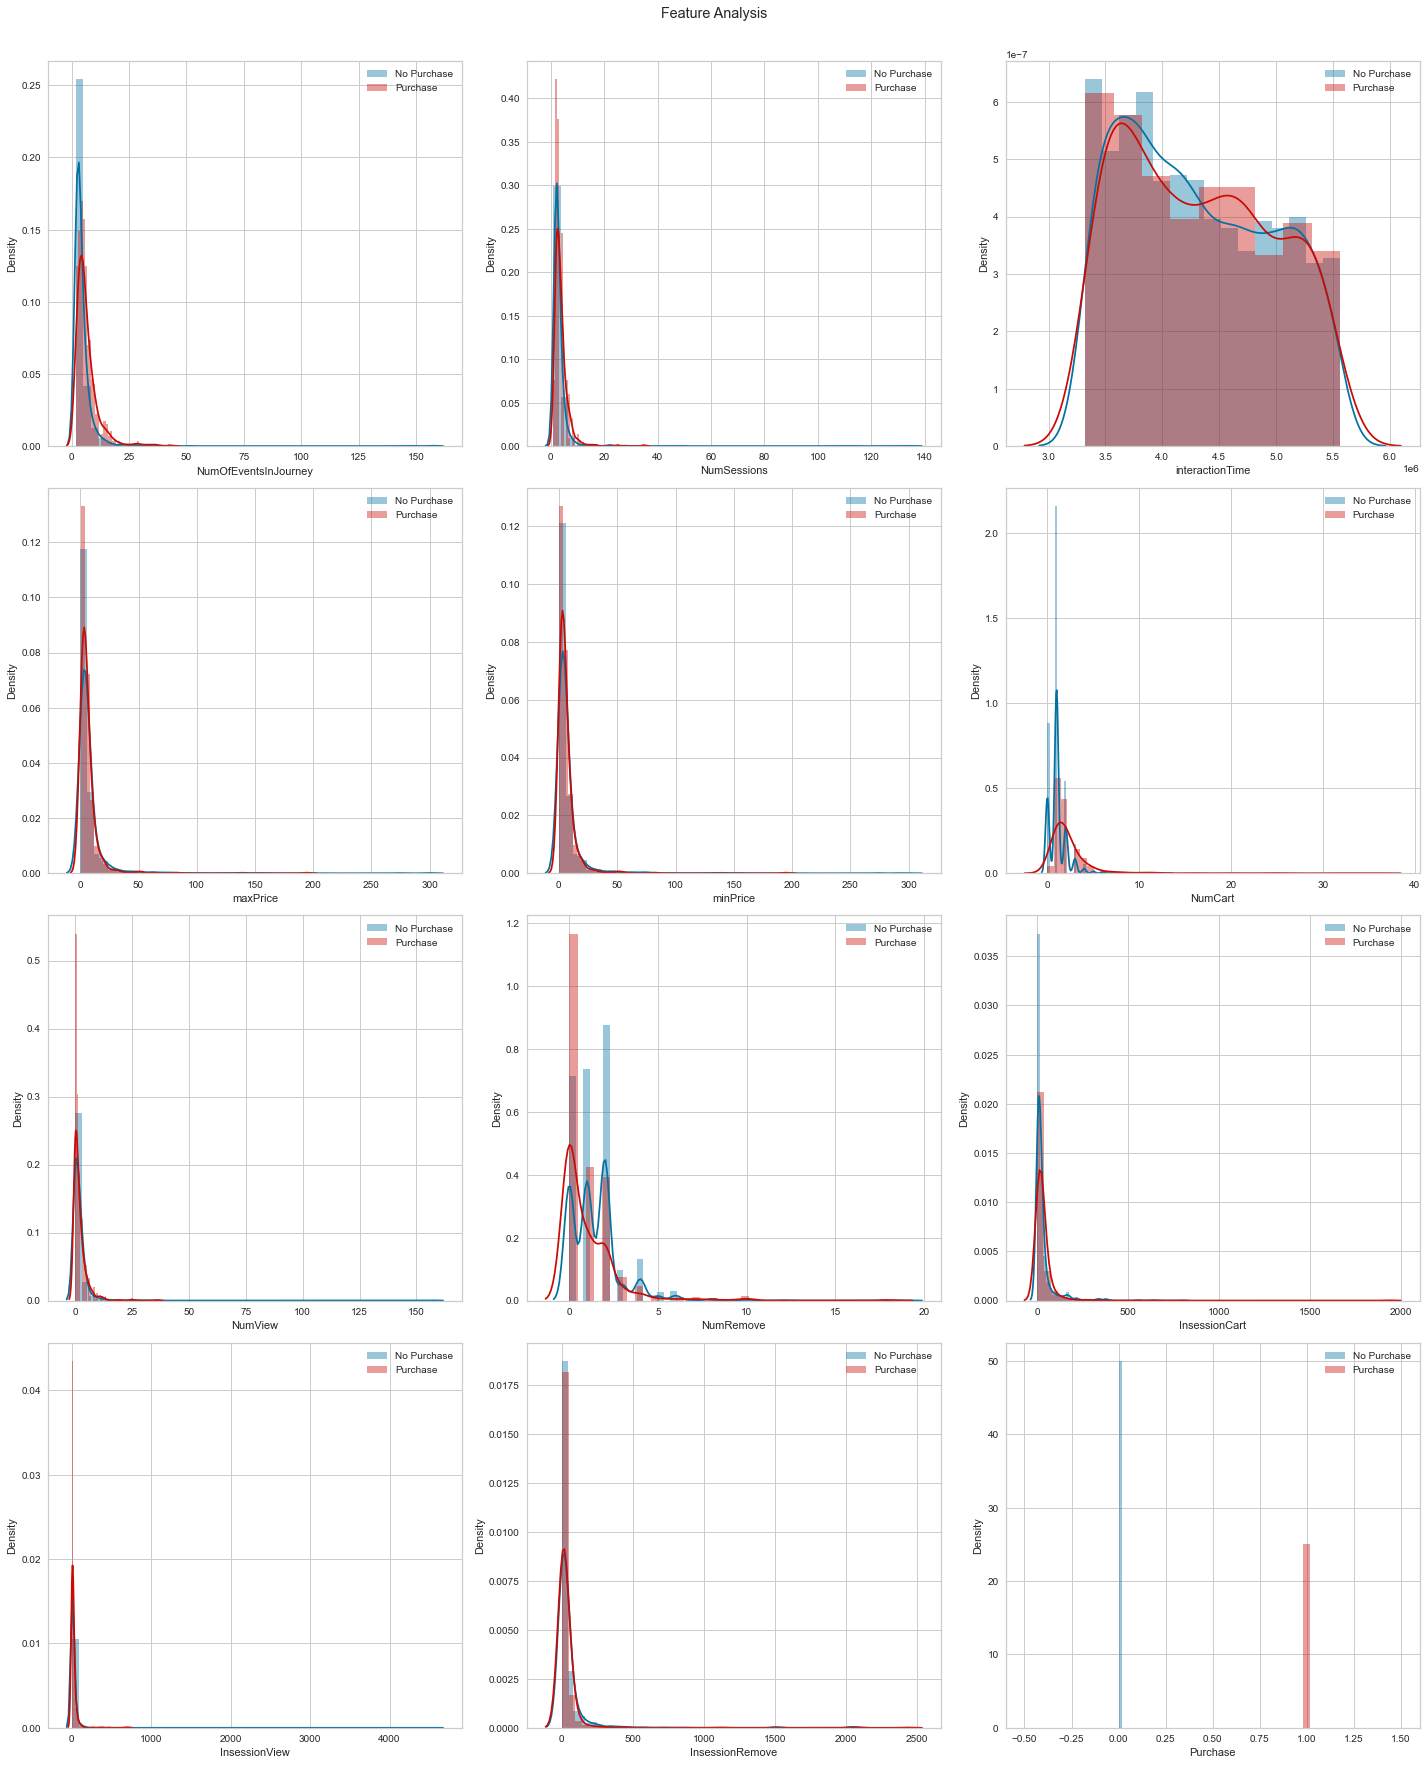

In [154]:
plot_discriminating_features(2)

**Cluster 3**

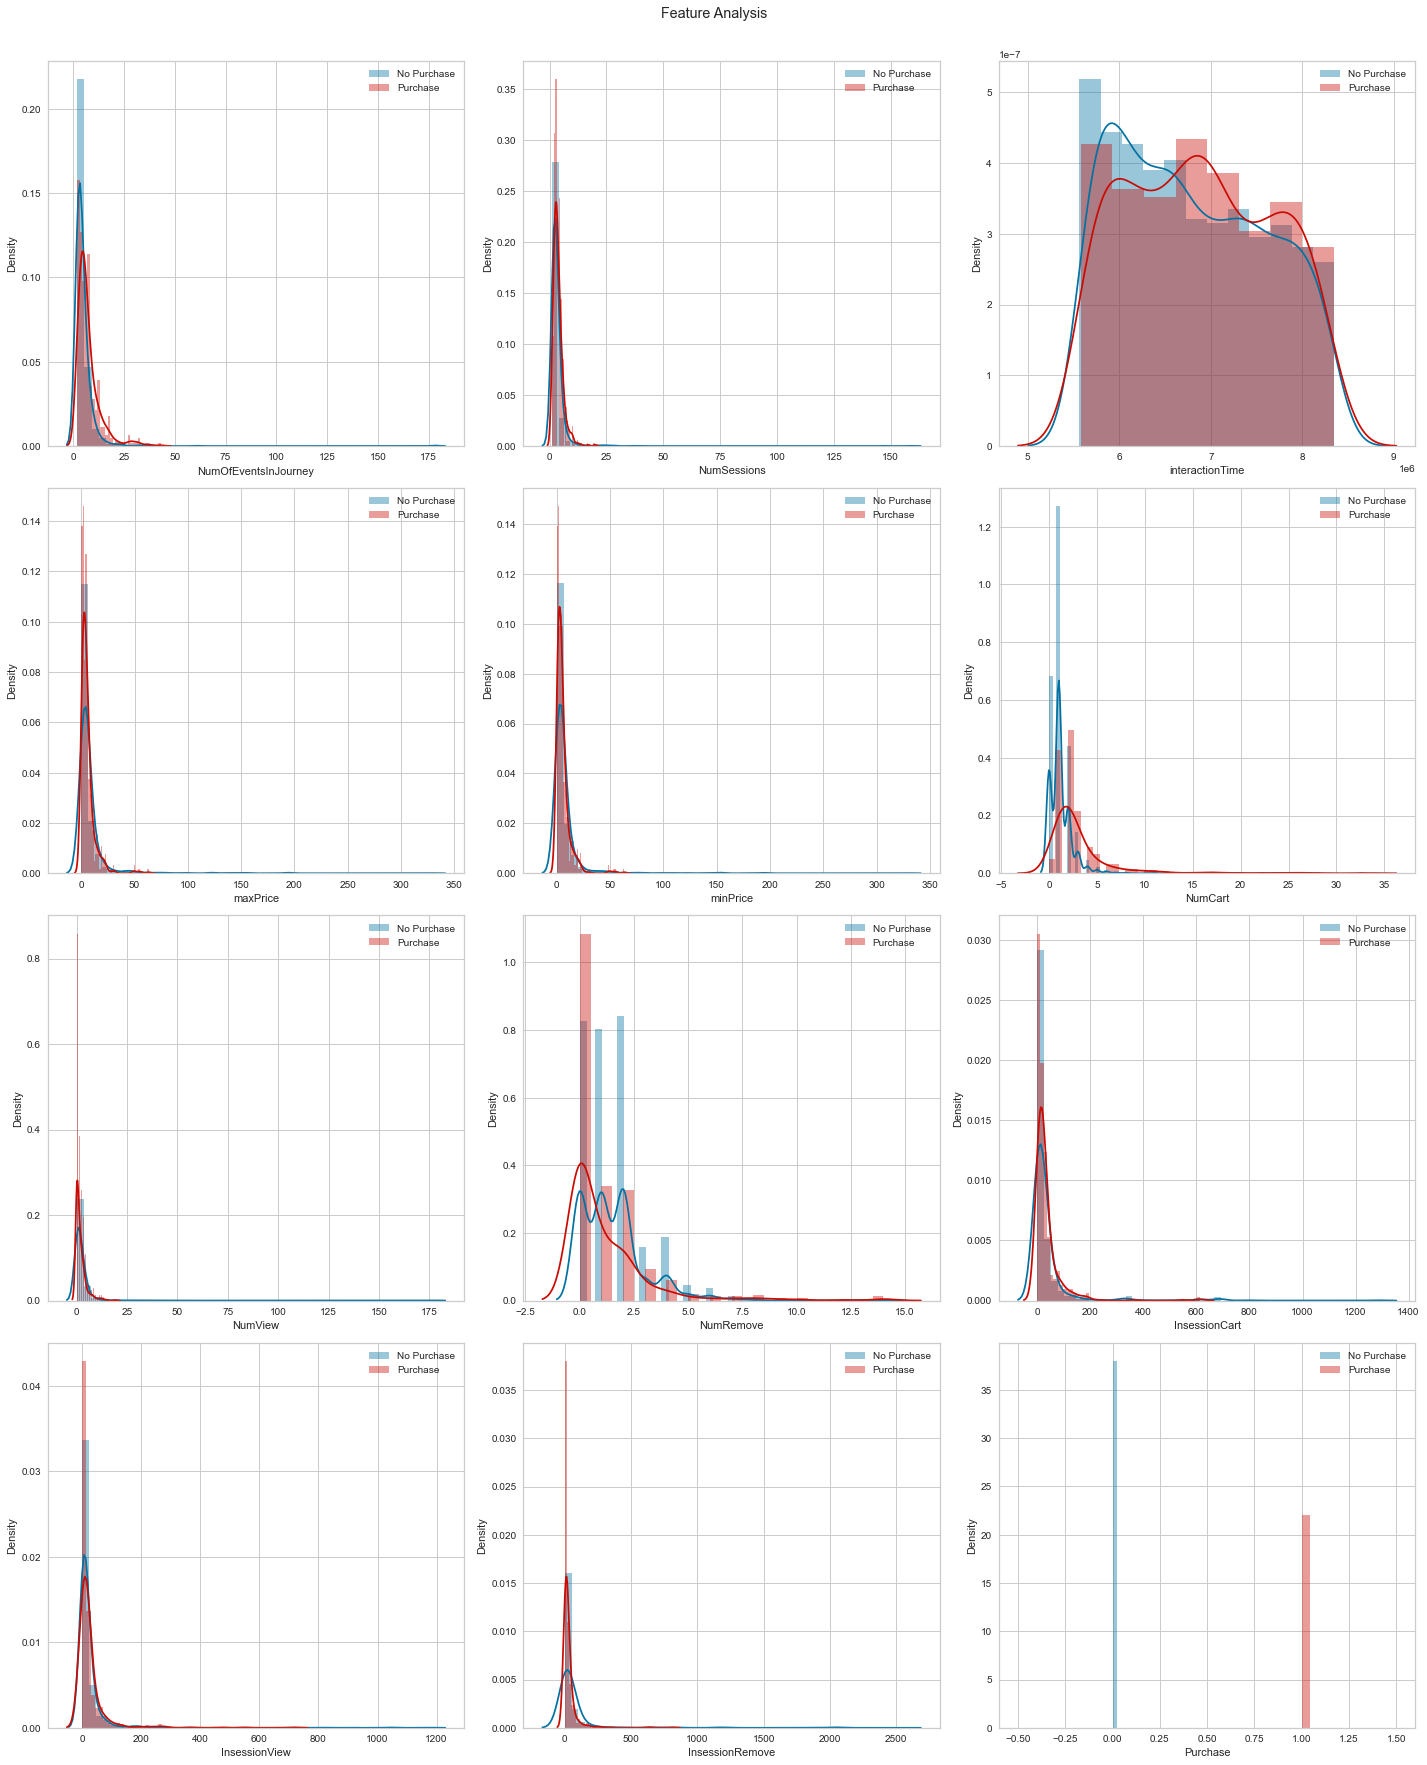

In [155]:
plot_discriminating_features(3)

**Cluster 4**

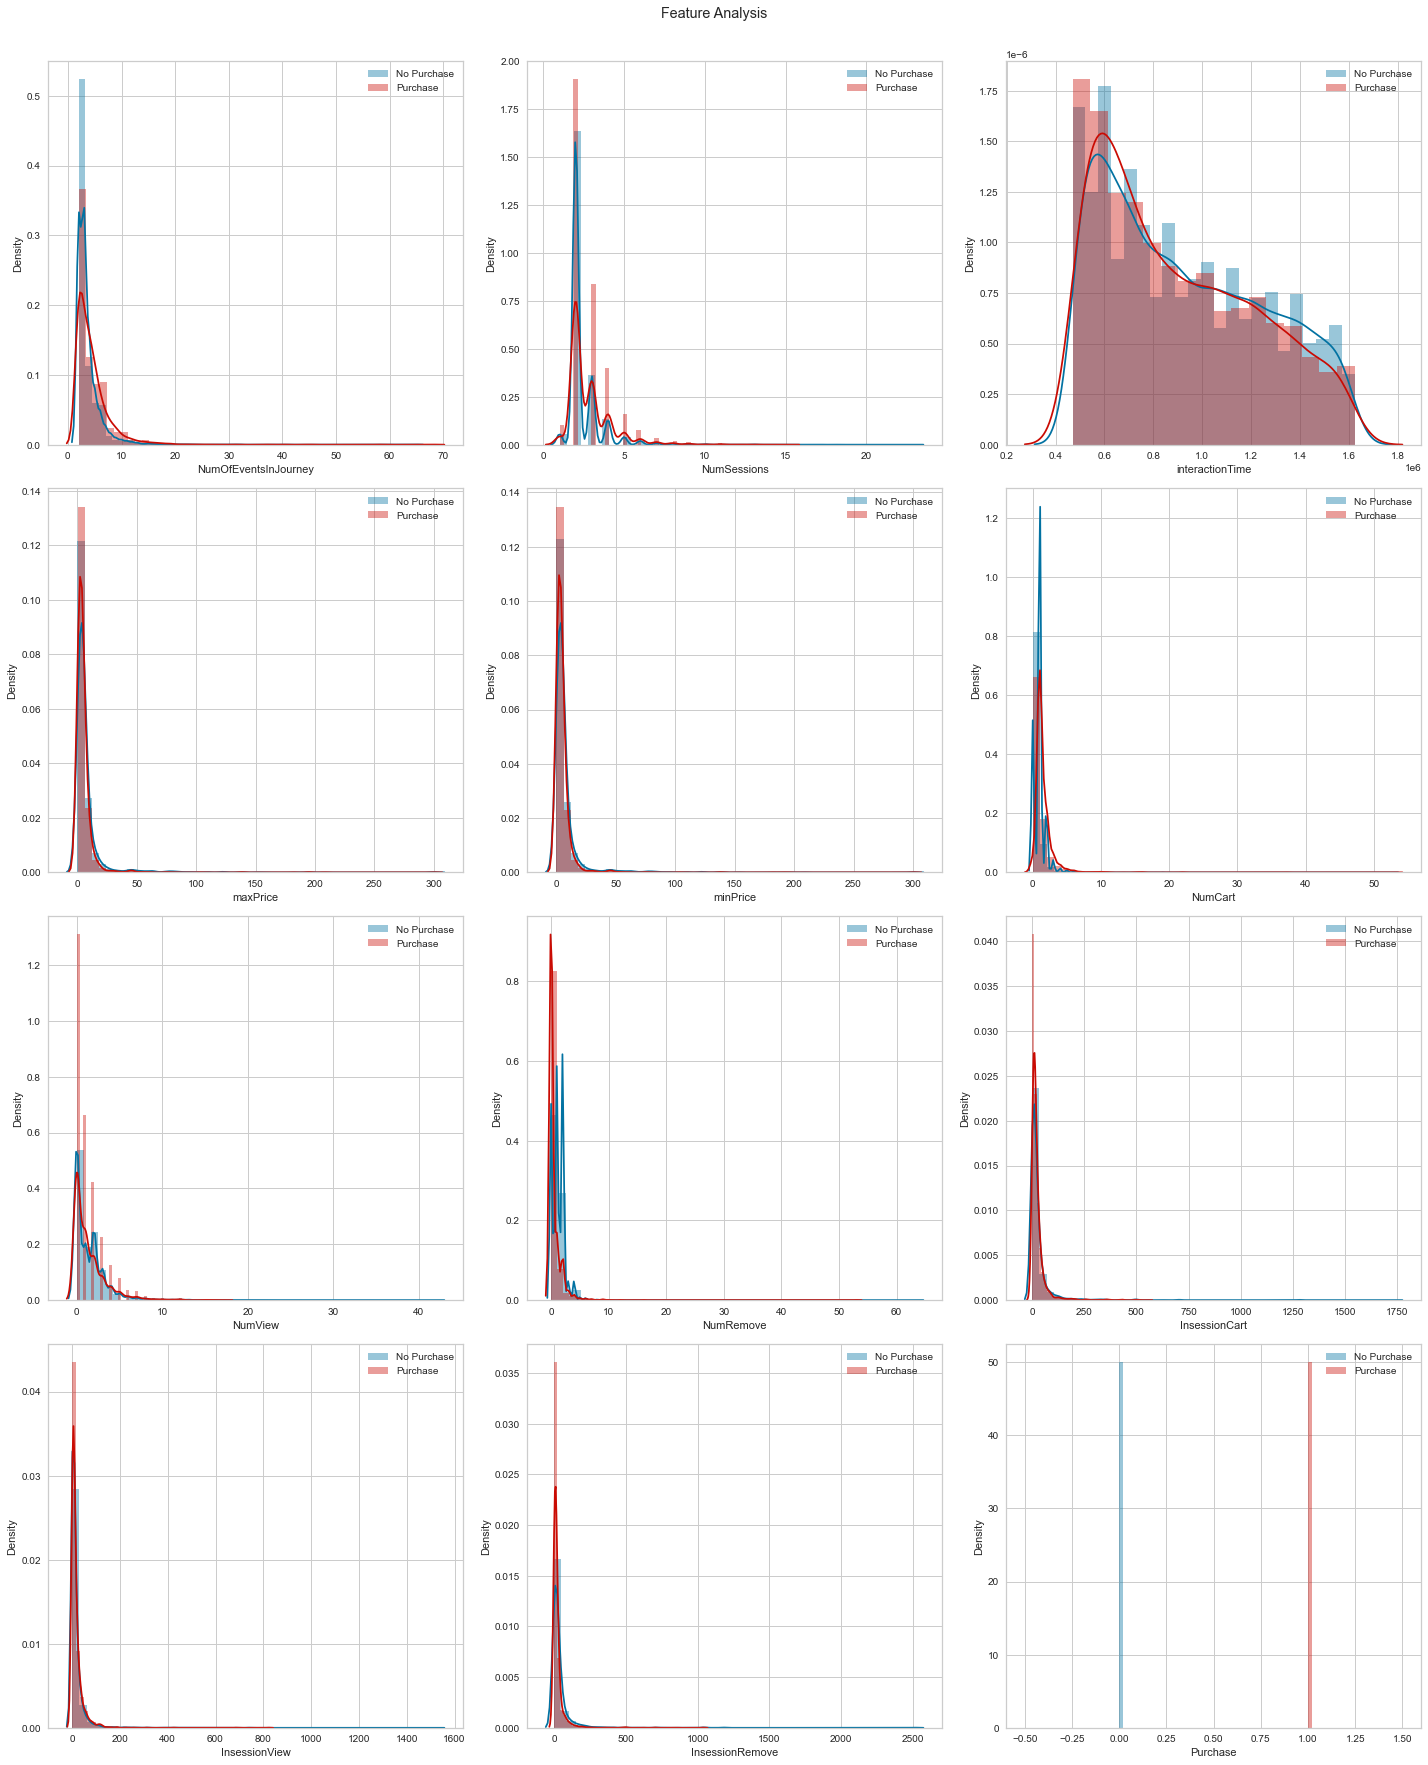

In [156]:
plot_discriminating_features(4)

**Cluster 5**

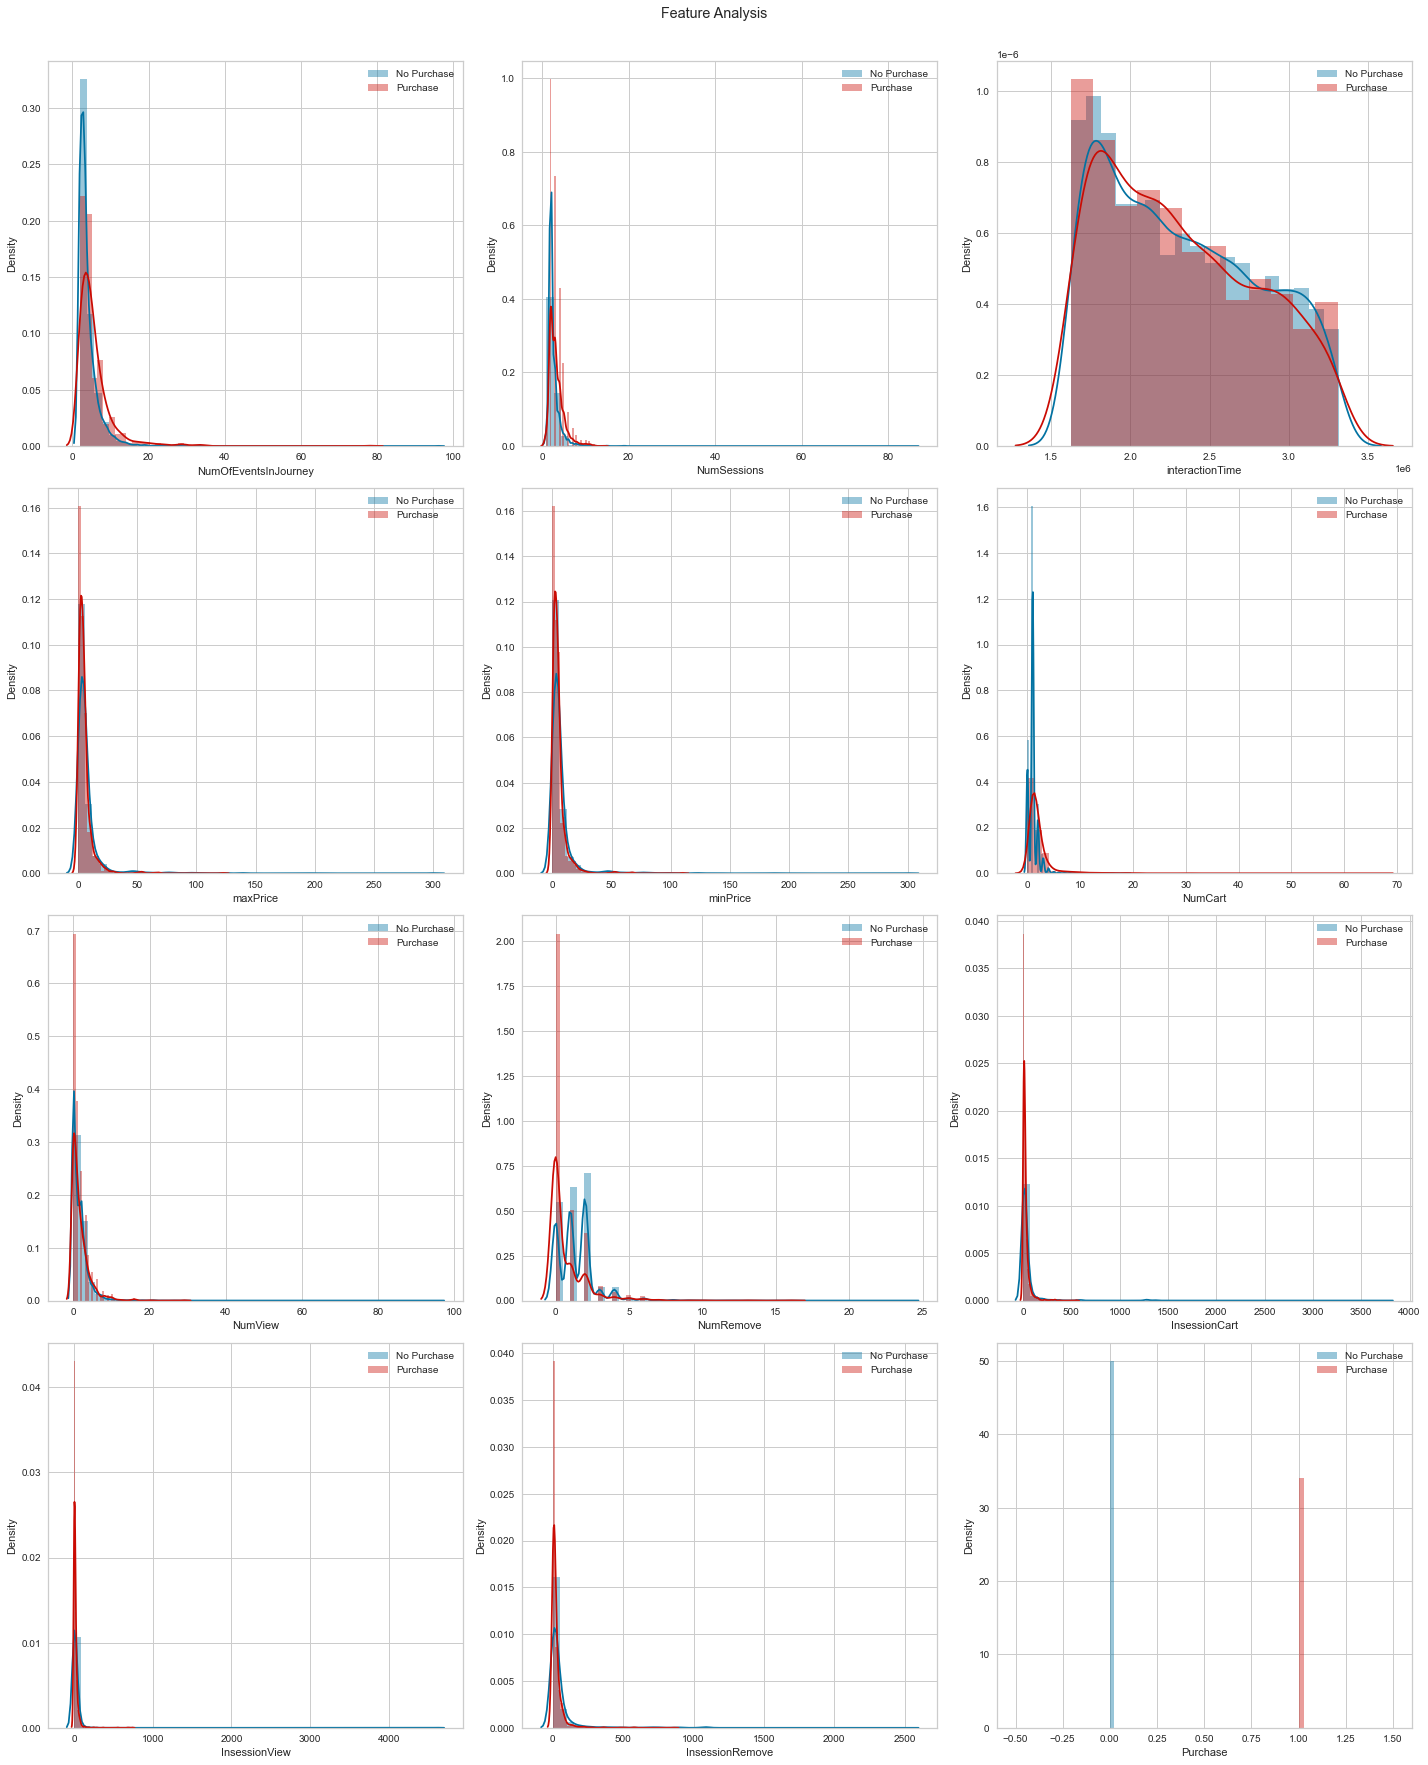

In [157]:
plot_discriminating_features(5)